# 3. Polynomial Regression, Train/Test Splitting and Overfitting/Underfitting

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (25/11/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Sklearn (tested on v0.0.post1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

### Mock dataset generation

This will be different compared to notebooks 1 and 2, as we will generate prices $ y_i $ as a polynomial function  of the surface $ x_i $.

In this notebook, we will assume that the function f(x), giving the price of an appartment with surface $ x $, will be defined as

$$ f(x) = 100000 + 14373x + 3x^3. $$

In addition, we will add a random noise to the final pricing, with a $ +/- 5\% $ drift as before.

As a final note, we will normalize the surfaces, by dividing the surface with the value of *max_surf*. This will help with visualization later on.

In [2]:
# All helper functions
min_surf = 40
max_surf = 150
def surface(min_surf, max_surf):
    # Note, we changed the surface inputs to be normalized by the value of max_surf.
    return round(np.random.uniform(min_surf, max_surf)/max_surf, 2)
def price(surface, max_surf):
    # Note: this will return the price in millions of SGD.
    surface = surface*max_surf
    return round((100000 + 14373*surface + 3*surface**3)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
def get_x_list(l):
    return [v[0] for v in l]
def get_y_list(l):
    return [v[1] for v in l]
def linreg(a, b, min_surf, max_surf, n_points = 50):
    return [(x, a*x + b) for x in np.linspace(min_surf/max_surf, 1, n_points)]
def loss_mse(a, b, x, y):
    val =  sum([(y_i - (a*x_i + b))**2 for x_i, y_i in zip(x, y)])/len(x)
    return '{:.2e}'.format(val)

In [3]:
# Dataset generation (n_points points will be generated).
# We will use a seed for reproducibility.
np.random.seed(47)
n_points = 50
dataset = [(s := surface(min_surf, max_surf), price(s, max_surf)) for _ in range(n_points)]
inputs = get_x_list(dataset)
outputs = get_y_list(dataset)
print(inputs)
print(outputs)

[0.35, 0.8, 0.79, 0.74, 0.78, 0.45, 0.34, 0.74, 0.4, 0.47, 0.97, 0.81, 0.89, 0.67, 0.64, 0.66, 0.27, 0.75, 0.81, 0.53, 0.67, 0.39, 0.37, 0.61, 0.37, 0.65, 0.38, 0.34, 0.55, 0.68, 0.75, 0.97, 0.91, 0.45, 0.59, 0.92, 0.83, 0.62, 0.59, 0.71, 0.98, 0.88, 0.62, 0.94, 0.56, 0.74, 0.68, 0.5, 0.9, 0.9]
[1.410984, 6.800555, 7.202396, 5.699261, 6.252742, 1.803106, 1.181844, 5.592118, 1.744748, 2.066473, 10.579514, 6.512015, 9.515465, 4.989233, 3.867465, 4.250671, 0.949053, 6.518132, 6.890678, 2.764555, 4.368185, 1.498484, 1.379271, 4.061492, 1.414585, 4.115157, 1.503426, 1.247709, 2.723618, 4.890328, 5.616256, 10.423832, 10.241848, 2.163041, 3.366671, 10.474156, 8.260908, 3.698003, 3.470893, 5.281104, 11.982039, 8.159346, 4.157982, 9.939658, 3.113319, 5.767716, 4.834484, 2.569699, 9.377195, 9.72469]


### Linear Regression

As in Notebook 2., using sklearn.

In [4]:
# Reshape inputs and outputs as a 2D np.array
sk_inputs = np.array(inputs).reshape(-1, 1)
sk_outputs = np.array(outputs)
# Creating a sklearn Linear Regressor.
# It uses the same analytical formula from earlier, i.e. W^* = (X^T X)^{-1} X^T Y.
reg = LinearRegression().fit(sk_inputs, sk_outputs)
# The coefficients for a* and b* are found using coeff_ and intercept_ respectively.
a_sk = reg.coef_[0]
b_sk = reg.intercept_
print("Value for a_star, found by sklearn: ", a_sk)
print("Value for b_star, found by sklearn: ", b_sk)

Value for a_star, found by sklearn:  15.09660685874144
Value for b_star, found by sklearn:  -4.808264574423615


Finally, we provide a display, showing the optimal linear regression model, in magenta, below.

Unfortunately, the data does not look linear anymore (as we defined the price function as a third degree polynomial function), which is why the linear regression does not fit the data that well.

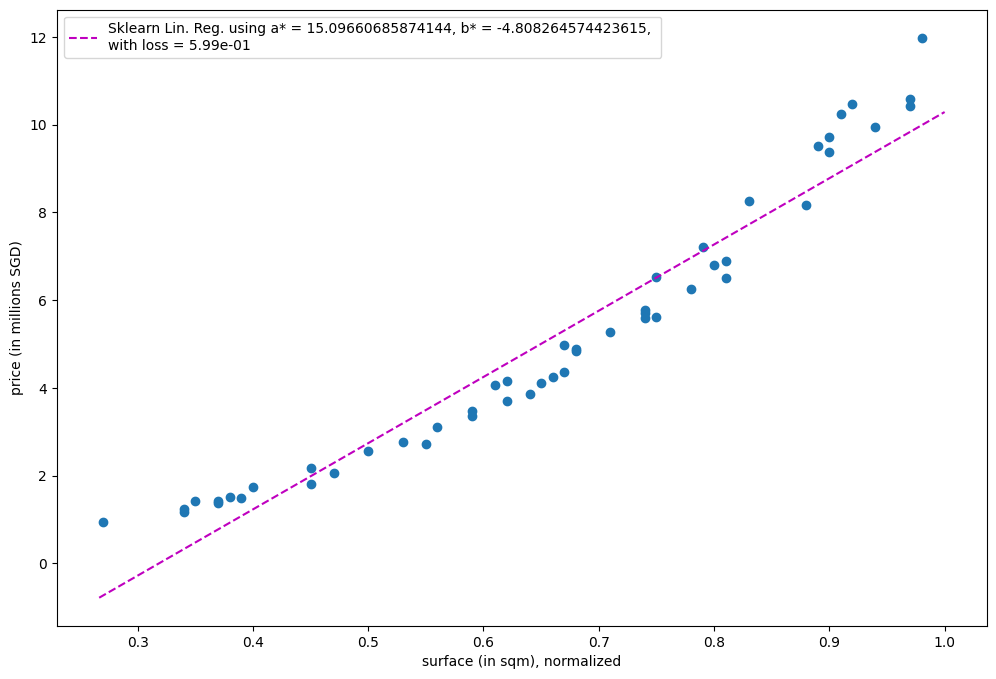

In [5]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs)
plt.xlabel("surface (in sqm), normalized")
plt.ylabel("price (in millions SGD)")

# Optimal linreg
linreg_dataset = linreg(a_sk, b_sk, min_surf, max_surf, n_points)
loss = loss_mse(a_sk, b_sk, inputs, outputs)
legend = "Sklearn Lin. Reg. using a* = {}, b* = {}, \nwith loss = {}".format(a_sk, b_sk, loss)
plt.plot(get_x_list(linreg_dataset), get_y_list(linreg_dataset), 'm--', label = legend)

# Display
plt.legend(loc = 'best')
plt.show()

### Polynomial Regression

Text

In [6]:
# Preparing polynomial features for our dataset
n_degree = 3
sk_poly = PolynomialFeatures(degree = n_degree, include_bias = False)
sk_poly_inputs = sk_poly.fit_transform(sk_inputs.reshape(-1, 1))
print(sk_poly_inputs)

[[0.35     0.1225   0.042875]
 [0.8      0.64     0.512   ]
 [0.79     0.6241   0.493039]
 [0.74     0.5476   0.405224]
 [0.78     0.6084   0.474552]
 [0.45     0.2025   0.091125]
 [0.34     0.1156   0.039304]
 [0.74     0.5476   0.405224]
 [0.4      0.16     0.064   ]
 [0.47     0.2209   0.103823]
 [0.97     0.9409   0.912673]
 [0.81     0.6561   0.531441]
 [0.89     0.7921   0.704969]
 [0.67     0.4489   0.300763]
 [0.64     0.4096   0.262144]
 [0.66     0.4356   0.287496]
 [0.27     0.0729   0.019683]
 [0.75     0.5625   0.421875]
 [0.81     0.6561   0.531441]
 [0.53     0.2809   0.148877]
 [0.67     0.4489   0.300763]
 [0.39     0.1521   0.059319]
 [0.37     0.1369   0.050653]
 [0.61     0.3721   0.226981]
 [0.37     0.1369   0.050653]
 [0.65     0.4225   0.274625]
 [0.38     0.1444   0.054872]
 [0.34     0.1156   0.039304]
 [0.55     0.3025   0.166375]
 [0.68     0.4624   0.314432]
 [0.75     0.5625   0.421875]
 [0.97     0.9409   0.912673]
 [0.91     0.8281   0.753571]
 [0.45    

In [7]:
# Training a Polynomial Regressor
poly_reg_model = LinearRegression()
poly_reg_model.fit(sk_poly_inputs, sk_outputs)
a_sk = poly_reg_model.coef_
b_sk = poly_reg_model.intercept_
print(a_sk, b_sk)

[-4.96614246 12.4891417   3.10710025] 1.3864109108902447


As before with the *linreg()* function, which we used to produce lists of values for displaying the model on matplotlib, we can come up with a *polyreg()* function. It basically does the same thing, but by using a polynomial function instead of a linear one. As explained in Notebook 2., we will rely on the *predict()* method, to be used on our trained model.

In [8]:
def polyreg(poly_reg_model, n_degree, min_surf, max_surf, n_points = 50):
    return [(x, poly_reg_model.predict(np.array([[x**(i+1) for i in range(n_degree)]]))) for x in np.linspace(min_surf/max_surf, 1, n_points)]

Finally, we provide a display, showing the optimal linear regression model, in magenta, below.

Unfortunately, the data does not look linear anymore (as we defined the price function as a third degree polynomial function), which is why the linear regression does not fit the data that well.

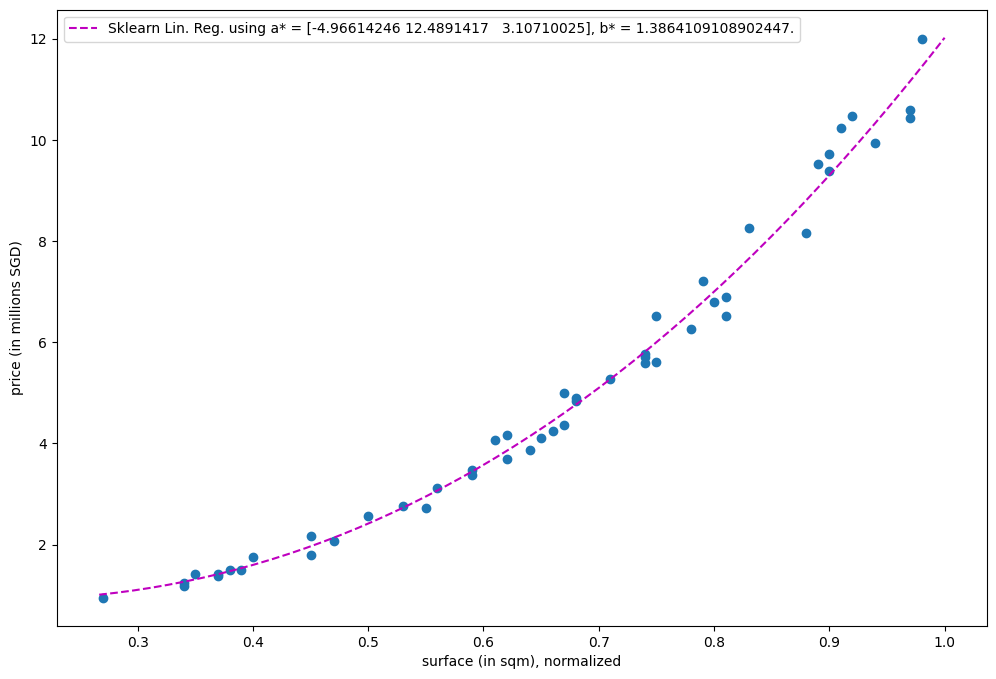

In [9]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs)
plt.xlabel("surface (in sqm), normalized")
plt.ylabel("price (in millions SGD)")

# Optimal linreg
polyreg_dataset = polyreg(poly_reg_model, n_degree, min_surf, max_surf, n_points)
legend = "Sklearn Lin. Reg. using a* = {}, b* = {}.".format(a_sk, b_sk)
plt.plot(get_x_list(polyreg_dataset), get_y_list(polyreg_dataset), 'm--', label = legend)

# Display
plt.legend(loc = 'best')
plt.show()

### Polynomial Regression (higher degree)

Text

In [10]:
# Preparing polynomial features for our dataset
n_degree2 = 10
sk_poly2 = PolynomialFeatures(degree = n_degree2, include_bias = False)
sk_poly_inputs2 = sk_poly2.fit_transform(sk_inputs.reshape(-1, 1))
print(sk_poly_inputs2)

[[3.50000000e-01 1.22500000e-01 4.28750000e-02 1.50062500e-02
  5.25218750e-03 1.83826562e-03 6.43392969e-04 2.25187539e-04
  7.88156387e-05 2.75854735e-05]
 [8.00000000e-01 6.40000000e-01 5.12000000e-01 4.09600000e-01
  3.27680000e-01 2.62144000e-01 2.09715200e-01 1.67772160e-01
  1.34217728e-01 1.07374182e-01]
 [7.90000000e-01 6.24100000e-01 4.93039000e-01 3.89500810e-01
  3.07705640e-01 2.43087456e-01 1.92039090e-01 1.51710881e-01
  1.19851596e-01 9.46827608e-02]
 [7.40000000e-01 5.47600000e-01 4.05224000e-01 2.99865760e-01
  2.21900662e-01 1.64206490e-01 1.21512803e-01 8.99194740e-02
  6.65404108e-02 4.92399040e-02]
 [7.80000000e-01 6.08400000e-01 4.74552000e-01 3.70150560e-01
  2.88717437e-01 2.25199601e-01 1.75655689e-01 1.37011437e-01
  1.06868921e-01 8.33577583e-02]
 [4.50000000e-01 2.02500000e-01 9.11250000e-02 4.10062500e-02
  1.84528125e-02 8.30376563e-03 3.73669453e-03 1.68151254e-03
  7.56680643e-04 3.40506289e-04]
 [3.40000000e-01 1.15600000e-01 3.93040000e-02 1.33633600e

In [11]:
# Training a Polynomial Regressor
poly_reg_model2 = LinearRegression()
poly_reg_model2.fit(sk_poly_inputs2, sk_outputs)
a_sk2 = poly_reg_model2.coef_
b_sk2 = poly_reg_model2.intercept_
print(a_sk2, b_sk2)

[  -247165.80803749   2080768.66543661 -10162335.22327691
  31907819.16537395 -67344325.33021776  96828802.17950758
 -93718588.85508816  58479947.15482696 -21259454.97221804
   3421623.27173629] 12926.700459353522


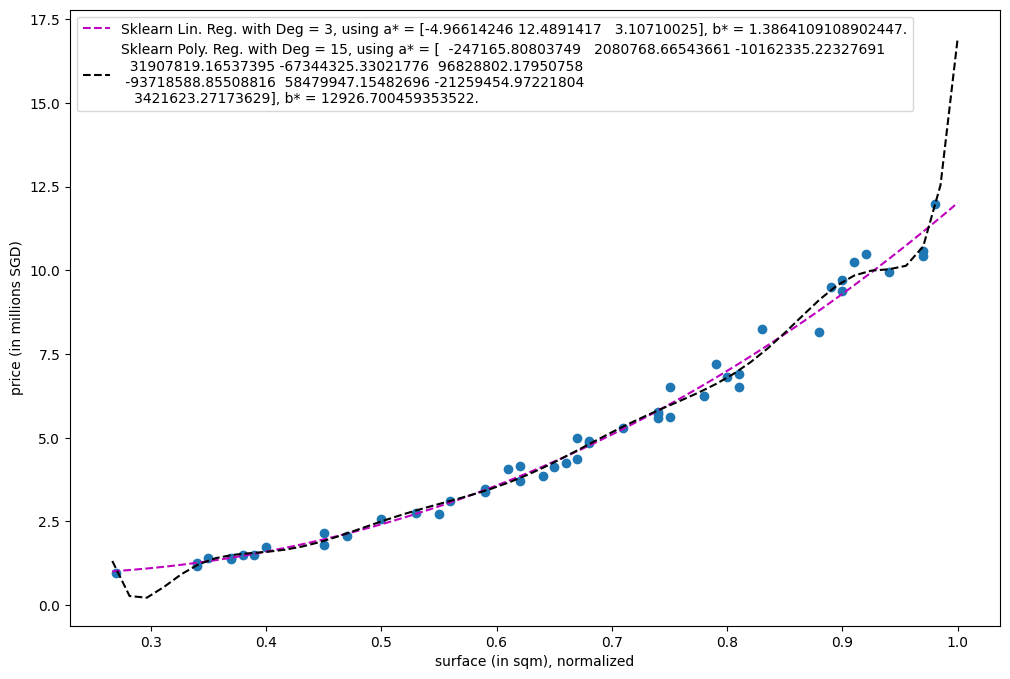

In [12]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs)
plt.xlabel("surface (in sqm), normalized")
plt.ylabel("price (in millions SGD)")

# Optimal linreg
polyreg_dataset = polyreg(poly_reg_model, n_degree, min_surf, max_surf, n_points)
legend = "Sklearn Lin. Reg. with Deg = 3, using a* = {}, b* = {}.".format(a_sk, b_sk)
plt.plot(get_x_list(polyreg_dataset), get_y_list(polyreg_dataset), 'm--', label = legend)

# Optimal linreg
polyreg_dataset2 = polyreg(poly_reg_model2, n_degree2, min_surf, max_surf, n_points)
legend2 = "Sklearn Poly. Reg. with Deg = 15, using a* = {}, b* = {}.".format(a_sk2, b_sk2)
plt.plot(get_x_list(polyreg_dataset2), get_y_list(polyreg_dataset2), 'k--', label = legend2)

# Display
plt.legend(loc='best')
plt.show()

In [13]:
def theoretical_values(surface, max_surf):
    avg_val = round((100000 + 14373*surface + 3*surface**3))/1000000
    min_val = 0.9*avg_val
    max_val = 1.1*avg_val
    return [min_val, avg_val, max_val]

In [14]:
new_appt_surface1 = 46
pred_price1 = poly_reg_model.predict(np.array([[(new_appt_surface1/max_surf)**(i+1) for i in range(n_degree)]]))[0]
print(pred_price1, theoretical_values(new_appt_surface1, max_surf))
new_appt_surface2 = 52
pred_price2 = poly_reg_model.predict(np.array([[(new_appt_surface2/max_surf)**(i+1) for i in range(n_degree)]]))[0]
print(pred_price2, theoretical_values(new_appt_surface2, max_surf))

1.1276046406759745 [0.9478494000000001, 1.053166, 1.1584826000000001]
1.2951790134309784 [1.142298, 1.26922, 1.3961420000000002]


In [15]:
new_appt_surface1 = 46
pred_price1b = poly_reg_model2.predict(np.array([[(new_appt_surface1/max_surf)**(i+1) for i in range(n_degree2)]]))[0]
print(pred_price1b, theoretical_values(new_appt_surface1, max_surf))
new_appt_surface2 = 52
pred_price2b = poly_reg_model2.predict(np.array([[(new_appt_surface2/max_surf)**(i+1) for i in range(n_degree2)]]))[0]
print(pred_price2b, theoretical_values(new_appt_surface2, max_surf))

0.42167172623157967 [0.9478494000000001, 1.053166, 1.1584826000000001]
1.2943844811579766 [1.142298, 1.26922, 1.3961420000000002]
